# **CISC3024 Pattern Recognition Final Project**
## Group Members:
- Huang Yanzhen, DC126732
- Mai Jiajun, DC127853

# 0. Project Setup

## 0.1 Packages & Device

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm

import numpy as np
import cv2
import os
import time

In [2]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print(f"Using device: {device_name}")

Using device: cuda


## 0.2 Global Configurations

In [3]:
path_dataset = "./data/SVHN_mat"
norm_mean = [0.4377, 0.4438, 0.4728]
norm_std = [0.1980, 0.2010, 0.1970]

# 1. Data Processing and Augmentation

## 1.1 Download Datasets
Define dataset class, retrieve dataset.

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import scipy.io as sio

In [5]:
class SVHNDataset(Dataset):
    def __init__(self, mat_file, transform=None):
        data = sio.loadmat(mat_file)
        self.images = np.transpose(data['X'], (3, 0, 1, 2))
        self.labels = data['y'].flatten()
        self.labels[self.labels == 10] = 0
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

In [6]:
transform = A.Compose([
    A.RandomResizedCrop(32, 32),
    A.Rotate(limit=30),
    A.Normalize(mean=norm_mean, std=norm_std),
    ToTensorV2()
])

train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"train_32x32.mat"), transform=transform)
test_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"test_32x32.mat"), transform=transform)
extra_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"extra_32x32.mat"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
extra_loader = DataLoader(Subset(extra_dataset, indices=list(range(30000))), batch_size=64, shuffle=False)

print(f"Train Size:{train_dataset.__len__()}\nTest Size:{test_dataset.__len__()}\nExtra Size:{extra_dataset.__len__()}")

Train Size:73257
Test Size:26032
Extra Size:531131


## 1.2 Peak A Data

In [7]:
import random

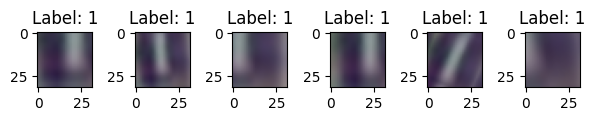

Peaking data from training set of index 6933.
Image Tnesor Size:torch.Size([3, 32, 32])


In [8]:
def unnormalize(img, mean, std):
    """Revert the normalization for visualization."""
    img = img * std + mean
    return np.clip(img, 0, 1)

# Plotting multiple images in a grid
grid_rows, grid_cols = 1, 6

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(6, 6))

peak_index = random.randint(0, train_dataset.__len__()-1)

for i in range(grid_cols):
    img_tensor, label = train_dataset.__getitem__(peak_index)
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    img = unnormalize(img, norm_mean, norm_std)

    ax = axes[i]  # Get subplot axis
    ax.imshow(img)
    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

print(f"Peaking data from training set of index {peak_index}.\nImage Tnesor Size:{train_dataset.__getitem__(peak_index)[0].shape}")

# 2. Neuron Network Structure

## 2.1 Specify Model Structure

In [9]:
class SmallVGG(nn.Module):
    def __init__(self, frame_size=32):
        super(SmallVGG, self).__init__()
        self.frame_size = frame_size
        self. conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4x4
        )
    
        self.fc_layers = nn.Sequential(
            nn.Linear(frame_size * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## 2.2 Initialize with Hyper Parameters

In [10]:
num_epochs = 30
learning_rate = 0.001
model = SmallVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 2.3 Train and Evaluate

In [11]:
def train_and_evaluate(model,
                      train_loader,
                      test_loader,
                      criterion,
                      optimizer,
                      num_epochs=100):
    # Record Losses to plot
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(images)
        train_losses.append(running_loss / len(train_loader))

        # Evaluate
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * len(images)

        test_losses.append(test_loss / len(test_loader))
        print(f"Epoch[{epoch+1}/{num_epochs}], Train Loss:{train_losses[-1]:.4f}, Test Loss:{test_losses[-1]:.4f}")

    return train_losses, test_losses

In [12]:
train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs)
torch.save(model.state_dict(), f"./models/small_vgg_ne-{num_epochs}_lr-{learning_rate:.0e}.pth")

100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:14<00:00, 38.78it/s]


Epoch[1/30], Train Loss:269.0844, Test Loss:224.3931


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.24it/s]


Epoch[2/30], Train Loss:183.8657, Test Loss:152.7722


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.05it/s]


Epoch[3/30], Train Loss:148.5520, Test Loss:139.2264


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.96it/s]


Epoch[4/30], Train Loss:136.3398, Test Loss:132.5165


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.10it/s]


Epoch[5/30], Train Loss:129.5036, Test Loss:126.3486


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.84it/s]


Epoch[6/30], Train Loss:125.4178, Test Loss:120.2768


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.90it/s]


Epoch[7/30], Train Loss:121.9030, Test Loss:117.5329


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.03it/s]


Epoch[8/30], Train Loss:119.4886, Test Loss:115.2610


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.18it/s]


Epoch[9/30], Train Loss:117.4120, Test Loss:112.0038


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.63it/s]


Epoch[10/30], Train Loss:114.4023, Test Loss:110.8437


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.93it/s]


Epoch[11/30], Train Loss:114.2462, Test Loss:106.9263


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.33it/s]


Epoch[12/30], Train Loss:113.2152, Test Loss:107.3380


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 30.98it/s]


Epoch[13/30], Train Loss:111.3432, Test Loss:103.5555


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.84it/s]


Epoch[14/30], Train Loss:110.4658, Test Loss:105.3292


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.02it/s]


Epoch[15/30], Train Loss:109.5433, Test Loss:102.8350


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.97it/s]


Epoch[16/30], Train Loss:109.4585, Test Loss:103.0470


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.69it/s]


Epoch[17/30], Train Loss:107.8355, Test Loss:102.9982


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.78it/s]


Epoch[18/30], Train Loss:107.3608, Test Loss:106.8535


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 31.94it/s]


Epoch[19/30], Train Loss:107.7781, Test Loss:100.5108


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.58it/s]


Epoch[20/30], Train Loss:106.8044, Test Loss:99.5869


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.35it/s]


Epoch[21/30], Train Loss:106.0726, Test Loss:99.3662


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.34it/s]


Epoch[22/30], Train Loss:105.9276, Test Loss:100.2521


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:18<00:00, 31.73it/s]


Epoch[23/30], Train Loss:104.3199, Test Loss:99.2494


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.52it/s]


Epoch[24/30], Train Loss:104.3040, Test Loss:100.1059


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.01it/s]


Epoch[25/30], Train Loss:104.2286, Test Loss:97.9395


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.19it/s]


Epoch[26/30], Train Loss:103.6763, Test Loss:98.8155


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.03it/s]


Epoch[27/30], Train Loss:104.1006, Test Loss:97.7697


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.23it/s]


Epoch[28/30], Train Loss:103.2498, Test Loss:101.0847


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.77it/s]


Epoch[29/30], Train Loss:103.6581, Test Loss:96.2499


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:17<00:00, 32.21it/s]


Epoch[30/30], Train Loss:102.7017, Test Loss:98.2706


## 2.4 Visualize Result
Multiple functions are defined to evaluate data. Below is a list of them.

#### `get_predictions`
Get a model prediction on 30,000 data on `extra.mat`.
- params:
    - `model_path`: The directory at which the model is stored.
    - `extra_loader`: The `DataLoader` object for loading `extra.mat`.
- returns:
    - `pred_scores`: A list of softmax-normalized predictions, one list of probabilities per image.
    - `true_labels`: A list of ground-truth labels.
    - `pred_labels`: A list of predicted labels.
---

#### `display_cm`
Plots the Confusion Matrix.
- params:
    - `true_labels`: A list of ground-truth labels.
    - `pred_labels`: A list of predicted labels.
- returns: `None`
---

#### `get_metrics`
Get evaluation metrics based on the given prediction results.
- params:
    - `true_labels`: A list of ground-truth labels.
    - `pred_labels`: A list of predicted labels.
- returns:
    - `accuracy`: A single universal accuracy. $acc=\dfrac{\text{\#. of correctly classified data}}{\text{\#. of data}}$
    - `precision`: A class-wise list of classification precisions. $P_i=\dfrac{TP}{TP+TN}$
    - `recall`: A class-wise list of classification recalls. $R_i=\dfrac{TP}{TP+FP}$
    - `f1`: A class-wise list of harmonic mean of precision and recall. $F_1=\dfrac{P+R}{2PR}$
---

#### `display_pr_curve`
Plot the precision-recall curve.
- params:
    - `true_labels`: A list of ground-truth labels.
    - `pred_scores`: A list of softmax-normalized predictions, one list of probabilities per image.
- returns: `None` 
---

#### `get_roc_auc`
Get the `roc_auc` scores.
- params:
    - `true_labels`: A list of ground-truth labels.
    - `pred_scores`: A list of softmax-normalized predictions, one list of probabilities per image.
- returns:
    - `roc_auc`: A class-wise list of `roc_auc` scores.
---

#### `display_roc_auc`
Plot the `roc` curve.
- params:
    - `true_labels`: A list of ground-truth labels.
    - `pred_scores`: A list of softmax-normalized predictions, one list of probabilities per image.
- returns: `None`

In [13]:
from sklearn.metrics import (confusion_matrix, accuracy_score,
                            precision_score, recall_score,
                            f1_score, roc_auc_score,
                            roc_curve, precision_recall_curve,
                            average_precision_score)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

### 2.4.0 Predict with Extra Data
First, use the trained model to predict 30,000 image data from `extra.mat`, which is unseen in neither `train.mat` nor `test.mat`. Robustness on `extra` proves the usability of the model.

Results may contain the following:
- Epoch-Loss Curve of model training
- Confusion Matrix
- Accuracy, Precision, Recall and $F_1$ score.

In [14]:
def get_predictions(model_path, extra_loader):
    model_state = torch.load(model_path)
    model = SmallVGG()
    model.load_state_dict(model_state)
    
    model.to(device)
    model.eval() 
    
    pred_scores = []  # Prob. of predictions
    true_labels = []  # Ground Truth
    pred_labels = []  # Label of prediction, i.e., argmax(softmax(pred_scores))
    
    with torch.no_grad():
        for images, labels in tqdm(extra_loader):
            images, labels = images.to(device), labels.to(device)
        
            outputs = model(images)
    
            pred_scores_batch = nn.functional.softmax(outputs, dim=-1)
    
            pred_scores.extend(pred_scores_batch.cpu().tolist())
            pred_labels.extend(outputs.argmax(dim=1).tolist())
            true_labels.extend(labels.cpu().tolist())
            
    return pred_scores, true_labels, pred_labels

In [15]:
pred_scores, true_labels_cpu, pred_labels_cpu = get_predictions("./models/small_vgg_ne-30_lr-1e-03.pth", extra_loader)
print("First 100 true labels:")
[print(num, end=" ") for num in true_labels_cpu[:100]]
print("...\n")

print("First 100 predictions:")
[print(num, end=" ") for num in pred_labels_cpu[:100]]
print("...\n")

print("Prediction Probabilities:")
[print(arr) for arr in pred_scores[:5]]
print("...")

D:\Temps\temp\ipykernel_29292\3475512123.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(model_path)
100%|██████████████████████████████████████

First 100 true labels:
4 7 8 7 1 1 7 4 3 0 2 8 8 3 1 1 7 0 8 1 5 6 4 4 4 6 3 4 4 3 0 1 7 6 0 1 1 0 5 7 5 1 8 5 5 2 9 6 1 5 2 3 5 3 6 9 2 3 4 1 7 7 3 1 2 2 0 1 1 3 1 5 1 1 9 9 4 8 0 5 1 3 8 2 9 5 6 0 7 8 3 0 6 4 0 3 1 1 0 0 ...

First 100 predictions:
4 1 8 7 7 1 7 4 3 0 2 8 0 3 1 1 7 0 8 1 6 6 4 4 4 6 3 4 4 3 0 7 7 6 0 1 1 0 2 7 5 1 4 5 3 2 9 6 1 4 6 3 5 3 6 7 2 3 4 1 7 7 3 1 2 2 2 1 1 3 1 5 1 1 9 9 4 3 0 5 1 3 9 2 0 6 6 0 7 8 3 1 6 4 0 7 1 1 1 8 ...

Prediction Probabilities:
[7.564401312265545e-05, 0.001672823098488152, 0.0010354656260460615, 0.0033441961277276278, 0.9874839186668396, 0.0007910538115538657, 0.0009172347490675747, 0.0022566476836800575, 0.0016073824372142553, 0.0008156428812071681]
[0.00012675659672822803, 0.9644230008125305, 0.0007670297054573894, 0.00124127056915313, 0.002548323478549719, 6.851315993117169e-05, 0.0006123455823399127, 0.02928384393453598, 0.0005660591996274889, 0.0003628291597124189]
[2.653884045855648e-08, 1.8440124449625728e-06, 1.6757052208049572e

### 2.4.1 Epoch-Loss Curves

In [16]:
def display_el_curve(train_losses, test_losses):
    plt.figure(figsize=(3,3))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Testing Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Testing Loss Curves")
    plt.legend()
    plt.show()

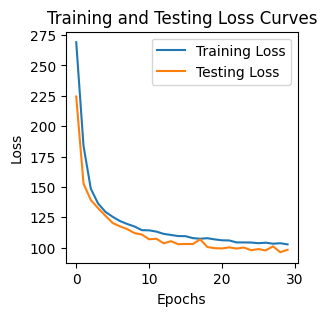

In [17]:
display_el_curve(train_losses, test_losses)

### 2.4.2 Confusion Matrix

In [18]:
def display_cm(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(0,10))
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

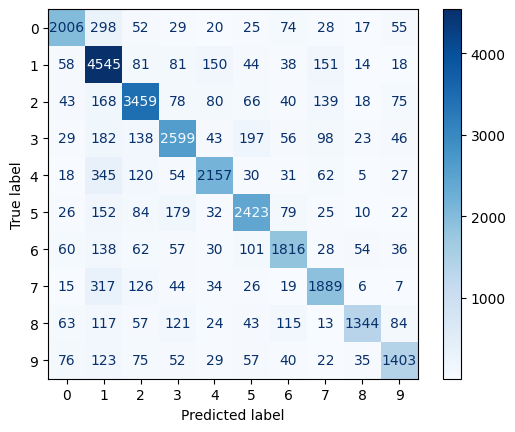

In [19]:
display_cm(true_labels_cpu, pred_labels_cpu)

### 2.4.3 Accuracy, Precision, Recall and $F_1$ Score

In [20]:
true_labels_bin = label_binarize(true_labels_cpu, classes=range(0,10))
true_labels_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [24]:
pred_labels_bin = label_binarize(pred_labels_cpu, classes=range(0,10))
pred_labels_bin

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [25]:
def get_metrics(true_labels, pred_labels):
    accuracy = accuracy_score(true_labels_cpu, pred_labels_cpu)
    precision = precision_score(true_labels_cpu, pred_labels_cpu, average=None, labels=range(0, 10))
    recall = recall_score(true_labels_cpu, pred_labels_cpu, average=None, labels=range(0, 10))
    f1 = f1_score(true_labels_cpu, pred_labels_cpu, average=None, labels=range(0, 10))

    return accuracy, precision, recall, f1

In [26]:
accuracy, precision, recall, f1 = get_metrics(true_labels_cpu, pred_labels_cpu)
print(f"Accuracy:{accuracy:.2f}")
for i in range(10):
    print(f"Class {i}: Prec:{precision[i]:.2f}, Recall:{recall[i]:.2f}, F_1 Score:{f1[i]:.2f}")

Accuracy:0.78
Class 0: Prec:0.82, Recall:0.78, F_1 Score:0.80
Class 1: Prec:0.74, Recall:0.84, F_1 Score:0.79
Class 2: Prec:0.76, Recall:0.84, F_1 Score:0.80
Class 3: Prec:0.77, Recall:0.78, F_1 Score:0.77
Class 4: Prec:0.75, Recall:0.79, F_1 Score:0.77
Class 5: Prec:0.83, Recall:0.79, F_1 Score:0.81
Class 6: Prec:0.79, Recall:0.72, F_1 Score:0.75
Class 7: Prec:0.77, Recall:0.75, F_1 Score:0.76
Class 8: Prec:0.85, Recall:0.67, F_1 Score:0.75
Class 9: Prec:0.84, Recall:0.70, F_1 Score:0.76


In [27]:
def display_pr_curve(true_labels_bin, pred_scores):
    for i in range(0, 10):
        precision_i, recall_i, _ = precision_recall_curve(true_labels_bin[:, i], np.array(pred_scores)[:, i])
        average_precision = average_precision_score(true_labels_bin[:, i], np.array(pred_scores)[:, i])
        plt.step(recall_i, precision_i, where="post", label=f"Class {i} AP={average_precision:.2f}")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
    plt.title("Precision-Recall Curve")
    plt.legend(loc="best")
    plt.show()

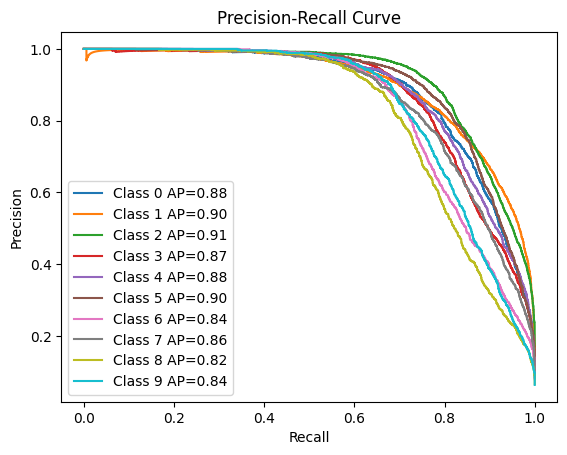

In [28]:
display_pr_curve(true_labels_bin, pred_scores)

### 2.4.4 ROC curve and ROC AUC
To compute ROC (Receiver Operating Characteristic), we need to first specify positive class using `label_binarize`.

In [29]:
# Compute ROC AUC for each class
def get_roc_auc(true_labels_bin, pred_labels_bin):
    roc_auc = dict()
    for i in range(0, 10):
        roc_auc[i] = roc_auc_score(true_labels_bin[:,i], np.array(pred_scores)[:, i])
    return roc_auc

In [30]:
roc_auc = get_roc_auc(true_labels_bin, pred_labels_bin)
for i, val in roc_auc.items():
    print(f"Class {i}: ROC AUC = {val:.2f}")

Class 0: ROC AUC = 0.98
Class 1: ROC AUC = 0.97
Class 2: ROC AUC = 0.98
Class 3: ROC AUC = 0.97
Class 4: ROC AUC = 0.98
Class 5: ROC AUC = 0.98
Class 6: ROC AUC = 0.96
Class 7: ROC AUC = 0.97
Class 8: ROC AUC = 0.96
Class 9: ROC AUC = 0.97


In [31]:
# Plot ROC AUC Curves
def display_roc_auc(true_labels_bin, pred_scores):
    for i in range(0, 10):
        fpr, tpr, _ = roc_curve(true_labels_bin[:,i], np.array(pred_scores)[:, i])
        plt.plot(fpr, tpr, label=f"Class {i}, AUC={roc_auc[i]:.2f}")
    
    plt.plot([0, 1], [0, 1], "k--") # Diagnal Line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # plt.yscale("logit")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()

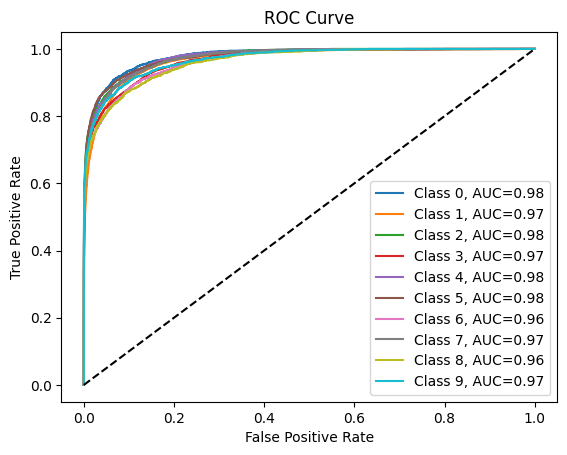

In [32]:
display_roc_auc(true_labels_bin, pred_scores)

# 3. Impact of Multiple Hyper-Parameters on Model Performance 

In [23]:
import itertools

Control candidates for different variables

In [24]:
# candidate_epoch_num = [20, 40, 60, 80]
# candidate_lr = [1e-3, 1e-4, 1e-5, 1e-6]
candidate_epoch_num = [20, 40]
candidate_lr = [1e-3, 1e-4]

From the controlled variables, generate all the possible experiment set.

In [25]:
combinations = list(itertools.product(candidate_epoch_num, candidate_lr))
for combo in combinations:
    print(f"[{combo[0]}, {combo[1]:.0e}]", end=" ")

[20, 1e-03] [20, 1e-04] [40, 1e-03] [40, 1e-04] 

In [26]:
def run_experiment(candidate_epoch_num, candidate_lr):
    combinations = list(itertools.product(candidate_epoch_num, candidate_lr))
    experiments = [] # Experiment Instances
    
    for combo in combinations:
        print(f"Performing Experiment: epoch_num={combo[0]}, lr={combo[1]}")
        exp_model = SmallVGG().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=combo[1])
        num_epochs = combo[0]
    
        train_losses, test_losses = train_and_evaluate(exp_model, train_loader, test_loader, criterion, optimizer, num_epochs)

        # One experiment instance
        experiments.append({
            "num_epoch": combo[0],
            "lr": combo[1],
            "train_losses": train_losses,
            "test_losses": test_losses,
            "model_state_dict": exp_model.state_dict()
        })
        
        # Prevent CUDA Mem Leak
        # del exp_model, criterion, optimizer
        # torch.cuda.empty_cache()
        
    return experiments

In [ ]:
experiments = run_experiment(candidate_epoch_num, candidate_lr)
time_str = str(time.time()).replace(".","")
torch.save(experiments, f"./models/experiments_{time_str}.pth")

In [29]:
loaded_experiments = torch.load("./models/experiments.pth")

D:\Temps\temp\ipykernel_6616\867694496.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_experiments = torch.load("./models/experiments.pth")


In [ ]:
n_rows = 4
n_cols = 4
fig_size = (15, 15)

fig, axes = plt.subplots(nrows=len(candidate_epoch_num), ncols=(candidate_lr), figsize=fig_size)
plt.tight_layout()

for i, ax in enumerate(axes.flat):
    train_losses, test_losses = loaded_experiments[i]["train_losses"], loaded_experiments[i]["test_losses"]

    train_difference = train_losses[-1]-train_losses[0]
    test_difference = test_losses[-1]-test_losses[0]
    
    ax.plot(train_losses, label=f"Training Loss, Diff={train_difference:.3f}")
    # ax.plot(test_losses, label=f"Testing Loss, Diff={test_difference:.3f}")
    # ax.xlabel("Epochs")
    # ax.ylabel("Loss")
    # ax.set_title(f"epoch_num={loaded_experiments[i]["num_epoch"]}, lr={loaded_experiments[i]["lr"]}")
    ax.legend()

plt.show()